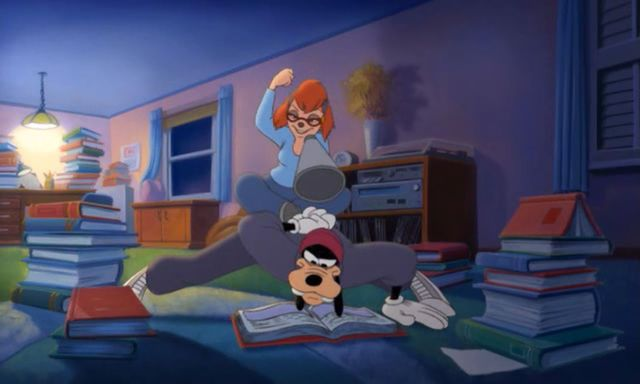
# Criação de banco de dados da Disney
Este notebook tem como objetivo coletar e limpar os dados de todos of filmes da Disney disponíveis na Wikipédia.

Lista: https://en.wikipedia.org/wiki/List_of_Walt_Disney_Pictures_films

## Coletando os dados

#### Carregando a página
Começaremos com o filme Toy Story 3.
https://en.wikipedia.org/wiki/Toy_Story_3

In [1]:
from bs4 import BeautifulSoup as bs
import requests

def get_content_value(row):
    """
    Função para lidar com casos onde há mais de um responsável por algo no
    filme. Onde ela irá ler o texto com os responsáveis e retornar uma lista
    com cada responsável.
    """
    row_list = row.select('ul li')
    info_list = []
    if row.select('ul li'):
        [info_list.append(info.get_text(' ',strip=True).replace(u'\xa0', u' ')) for info in row.select('ul li')]
        return info_list
    elif row.select('br'):
        info_list = [text.replace(u'\xa0', u' ') for text in row.find('td').stripped_strings]
        return info_list
    else:
        return row.select('td')[0].get_text(' ',strip=True).replace(u'\xa0', u' ')

def get_info_box(url):
    """
    A partir de uma url retorna as informações coletadas da tabela à direita da página
    """
    r = requests.get(url)
    soup = bs(r.content,'lxml')
    table = soup.select('table.infobox')[0]
    row_info = table.find_all('tr')
    movie_info = {}
    movie_info['Title'] = row_info[0].select('th')[0].text
    for i in range(2,len(table.find_all('tr'))):
        try:
            key = row_info[i].select('th')[0].get_text(' ',strip=True)
            info = get_content_value(row_info[i]) 
            movie_info[key] = info
        except:
            pass
    return movie_info

In [2]:
get_info_box("https://en.wikipedia.org/wiki/Toy_Story_3")

{'Title': 'Toy Story 3',
 'Directed by': 'Lee Unkrich',
 'Produced by': 'Darla K. Anderson',
 'Screenplay by': 'Michael Arndt',
 'Story by': ['John Lasseter', 'Andrew Stanton', 'Lee Unkrich'],
 'Starring': ['Tom Hanks',
  'Tim Allen',
  'Joan Cusack',
  'Don Rickles',
  'Wallace Shawn',
  'John Ratzenberger',
  'Estelle Harris',
  'Blake Clark',
  'Jeff Pidgeon',
  'Ned Beatty',
  'Michael Keaton',
  'Jodi Benson',
  'John Morris'],
 'Music by': 'Randy Newman',
 'Cinematography': ['Jeremy Lasky', 'Kim White'],
 'Edited by': 'Ken Schretzmann',
 'Production company': ['Walt Disney Pictures', 'Pixar Animation Studios'],
 'Distributed by': ['Walt Disney Studios', 'Motion Pictures'],
 'Release date': ['June 12, 2010 ( 2010-06-12 ) ( Taormina Film Fest )',
  'June 18, 2010 ( 2010-06-18 ) (United States)'],
 'Running time': '103 minutes [1]',
 'Country': 'United States',
 'Language': 'English',
 'Budget': '$200 million [1]',
 'Box office': '$1.067 billion [1]'}

#### Coletando os links de todas os filmes da lista.

Aqui usaremos a lista da Wikipédia para recolher os links da própria wiki com as informações dos filmes.

In [3]:
r = requests.get("https://en.wikipedia.org/wiki/List_of_Walt_Disney_Pictures_films")
soup = bs(r.content,'lxml')

In [4]:
all_tables = soup.find_all(class_='wikitable sortable')
url_path = []
for index, table in enumerate(all_tables):
    table = all_tables[index].select('i a')
    for table_index in range(len(table)):
        url = table[table_index]['href']
        if url.startswith('#cite'):
            pass #algumas url são de citações então pulamos elas
        else:
            url_path.append(url)

In [5]:
url_path

['/wiki/Academy_Award_Review_of_Walt_Disney_Cartoons',
 '/wiki/Snow_White_and_the_Seven_Dwarfs_(1937_film)',
 '/wiki/Pinocchio_(1940_film)',
 '/wiki/Fantasia_(1940_film)',
 '/wiki/The_Reluctant_Dragon_(1941_film)',
 '/wiki/Dumbo',
 '/wiki/Bambi',
 '/wiki/Saludos_Amigos',
 '/wiki/Victory_Through_Air_Power_(film)',
 '/wiki/The_Three_Caballeros',
 '/wiki/Make_Mine_Music',
 '/wiki/Song_of_the_South',
 '/wiki/Fun_and_Fancy_Free',
 '/wiki/Melody_Time',
 '/wiki/So_Dear_to_My_Heart',
 '/wiki/The_Adventures_of_Ichabod_and_Mr._Toad',
 '/wiki/Cinderella_(1950_film)',
 '/wiki/Treasure_Island_(1950_film)',
 '/wiki/Alice_in_Wonderland_(1951_film)',
 '/wiki/The_Story_of_Robin_Hood_and_His_Merrie_Men',
 '/wiki/Peter_Pan_(1953_film)',
 '/wiki/The_Sword_and_the_Rose',
 '/wiki/The_Living_Desert',
 '/wiki/Rob_Roy,_the_Highland_Rogue',
 '/wiki/The_Vanishing_Prairie',
 '/wiki/20,000_Leagues_Under_the_Sea_(1954_film)',
 '/wiki/Davy_Crockett,_King_of_the_Wild_Frontier',
 '/wiki/Lady_and_the_Tramp',
 '/wiki/Th

#### Entrando em cada link e coletando as informações

Usando as urls coletadas iremos acessar cada página e recolher as informações.

In [6]:
mother_url = 'https://en.wikipedia.org'
all_movies_info = []
for relative_path in url_path:
    try:
        movie_info = {}
        url_to_scrape = mother_url + relative_path
        movie_info = get_info_box(url_to_scrape)
        all_movies_info.append(movie_info) 
    except Exception as e:
        print(url_to_scrape)
        print(e)

https://en.wikipedia.org/wiki/True-Life_Adventures
list index out of range


Ao acessar a página da excessão podemos ver que não há informações sobre o filme na Wikipédia.

In [7]:
len(all_movies_info)

439

No final do processo obtemos informações sobre 439 filmes.

#### Transformando o dicionário em .json

Salvando os dados com um arquivo .json

In [8]:
import json

def save_data(filename, data):
    with open(filename,'w',encoding='utf-8') as f:
        json.dump(data,f,ensure_ascii=False,indent = 2)

def load_data(filename):
    with open(filename,'r',encoding='utf-8') as f:
        return json.load(f)

In [9]:
save_data('disney_data.json',all_movies_info)

## Limpando os dados

A maioria dos dados númericos está bastante sujo, aqui iremos transforma-los de forma a trabalhar melhor com eles para uma futura análise.

In [10]:
import re
from datetime import datetime

movie_info_list = load_data('disney_data.json')

Criando algumas funções para limpar os dados.

In [11]:
def clean_references(movie_info):
    """
    Remove referências da Wikipédia (ex:[1])
    """
    for key in movie_info:
        if isinstance(movie_info[key], list):
            for index, content in enumerate(movie_info[key]):
                movie_info[key][index] = re.sub(r'\[[^()]*\]','',content)
        else:
            movie_info[key]=re.sub(r'\[[^()]*\]','',movie_info[key])
    return movie_info

def clean_runtime(movie_info):
    """
    Transforma as informações de Running time em int.
    """
    try:
        if isinstance(movie_info['Running time'],list):
            # Alguns dados de Running time foram capturados como lista
            # aqui pegamos somente o primeiro item dessa lista
            movie_info['Running time'] = int(re.findall(r'\d+', movie_info['Running time'][0])[0])
            return movie_info
        else:
            movie_info['Running time'] = int(re.findall(r'\d+', movie_info['Running time'])[0])
            return movie_info
    except:
        # alguns filmes não tem Running time
        pass
    
def get_datetime(movie_info):
    """
    Lidando com os vários tipo de data presente nos dados coletados da
    Wikipédia.
    """
    try:
        if isinstance(movie_info['Release date'], list):
            try:
                datetime_str = movie_info['Release date'][0].split(' (')[0]
                movie_info['Release date'] = datetime.strptime(datetime_str, '%b %d, %Y')
                return movie_info
            except:
                pass
            try:
                datetime_str = movie_info['Release date'][0].split(' (')[0]
                movie_info['Release date'] = datetime.strptime(datetime_str, '%B %d, %Y')
                return movie_info
            except:
                pass
            try:
                datetime_str = movie_info['Release date'][0].split(' (')[0]
                movie_info['Release date'] = datetime.strptime(datetime_str, '%b %Y')
                return movie_info
            except:
                pass
            try:
                datetime_str = movie_info['Release date'][0].split(' (')[0]
                movie_info['Release date'] = datetime.strptime(datetime_str, '%Y')
                return movie_info
            except:
                pass
            try:
                datetime_str = movie_info['Release date'][0].split(' (')[0]
                movie_info['Release date'] = datetime.strptime(datetime_str, '%d %B %Y')
                return movie_info
            except:
                pass
        else:
            try:
                datetime_str = movie_info['Release date'].split(' (')[0]
                movie_info['Release date'] = datetime.strptime(datetime_str, '%b %d, %Y')
                return movie_info
            except:
                pass
            try:
                datetime_str = movie_info['Release date'].split(' (')[0]
                movie_info['Release date'] = datetime.strptime(datetime_str, '%B %d, %Y')
                return movie_info
            except:
                pass
            try:
                datetime_str = movie_info['Release date']
                movie_info['Release date'] = datetime.strptime(datetime_str, '%B %d, %Y ')
                return movie_info
            except:
                pass
            try:
                datetime_str = movie_info['Release date'].split(' ;')[0]
                movie_info['Release date'] = datetime.strptime(datetime_str, '%d %B %Y')
                return movie_info
            except:
                pass
            try:
                datetime_str = movie_info['Release date'].split(' (')[0]
                movie_info['Release date'] = datetime.strptime(datetime_str, '%d %B %Y')
                return movie_info
            except:
                pass
    except:
            try:
                datetime_str = movie_info.pop('Original release')
                datetime_str = datetime_str.split(' (')[0]
                movie_info['Release date'] = datetime.strptime(datetime_str, '%B %d, %Y')
                return movie_info
            except:
                movie_info['Release date'] = None
                return movie_info
            
def get_box_office(movie_info):
    """
    Transforma a informação de Box office em float
    """
    try:
        try:
            movie_info['Box office'] = movie_info['Box office'].replace('\n','')
            if movie_info['Box office'].find('$') == -1:
                # alguns filmes não estão em U$
                box_office = None
            elif movie_info['Box office'].find('billion') != -1:
                dollar_pos = movie_info['Box office'].find('$')
                bil_pos = movie_info['Box office'].find('billion')
                box_office = float(movie_info['Box office'][dollar_pos+1:bil_pos]) * 10**9
            elif movie_info['Box office'].find('million') != -1:
                dollar_pos = movie_info['Box office'].find('$')
                mil_pos = movie_info['Box office'].find('million')
                box_office = float(movie_info['Box office'][dollar_pos+1:mil_pos]) * 10**6
            elif movie_info['Box office'].find('million') == -1:
                # lidando com casos onde não se especifíca billion ou million
                dollar_pos = movie_info['Box office'].find('$')
                space_pos = movie_info['Box office'].find(' ',dollar_pos)
                if space_pos == -1:
                    space_pos = None
                box_office = float(movie_info['Box office'][dollar_pos+1:space_pos].replace(',', ''))
        except:
            # lidando com número não exatos (ex: $311-340)
            dollar_pos = movie_info['Box office'].find('$')
            slash_pos = movie_info['Box office'].find('–')
            box_office = float(movie_info['Box office'][dollar_pos+1:slash_pos])*10**6
        movie_info['Box office'] = box_office
        return movie_info
    except AttributeError:
        # lidando com alguns Box Office que estão como lista
        try:
            box_office = [box_offices for box_offices in movie_info['Box office'] if box_offices.find('$')!=-1][0]
            if box_office.find('$') == -1:
                box_office = None
            elif box_office.find('billion') != -1:
                dollar_pos = box_office.find('$')
                bil_pos = box_office.find('billion')
                box_office = float(box_office[dollar_pos+1:bil_pos]) * 10**9
            elif box_office.find('million') != -1:
                dollar_pos = box_office.find('$')
                mil_pos = box_office.find('million')
                box_office = float(box_office[dollar_pos+1:mil_pos]) * 10**6
            elif box_office.find('million') == -1:
                dollar_pos = box_office.find('$')
                space_pos = box_office.find(' ')
                if space_pos == -1:
                    space_pos = None
                box_office = float(box_office[dollar_pos+1:space_pos].replace(',', ''))
        except ValueError:
            box_office = [box_offices for box_offices in movie_info['Box office'] if box_offices.find('$')!=-1][0]
            dollar_pos = box_office.find('$')
            slash_pos = box_office.find('–')
            box_office = float(box_office[dollar_pos+1:slash_pos])*10**6
        movie_info['Box office'] = box_office
        return movie_info
    
# adaptando a função get_box_office para lidar com Budget
def get_budget(movie_info):
    """
    Transforma a informação de Budget em float
    """
    try:
        try:
            movie_info['Budget'] = movie_info['Budget'].replace('\n','')
            if movie_info['Budget'].find('$') == -1:
                box_office = None
            elif movie_info['Budget'].find('billion') != -1:
                dollar_pos = movie_info['Budget'].find('$')
                bil_pos = movie_info['Budget'].find('billion',dollar_pos)
                box_office = float(movie_info['Budget'][dollar_pos+1:bil_pos]) * 10**9
            elif movie_info['Budget'].find('million') != -1:
                dollar_pos = movie_info['Budget'].find('$')
                mil_pos = movie_info['Budget'].find('million',dollar_pos)
                box_office = float(movie_info['Budget'][dollar_pos+1:mil_pos]) * 10**6
            elif movie_info['Budget'].find('million') == -1:
                dollar_pos = movie_info['Budget'].find('$')
                space_pos = movie_info['Budget'].find(' ',dollar_pos)
                if space_pos == -1:
                    space_pos = None
                box_office = float(movie_info['Budget'][dollar_pos+1:space_pos].replace(',', ''))
        except:
            dollar_pos = movie_info['Budget'].find('$')
            slash_pos = movie_info['Budget'].find('–')
            if slash_pos == -1:
                slash_pos = movie_info['Budget'].find('-') # um traço diferente do de cima
            box_office = float(movie_info['Budget'][dollar_pos+1:slash_pos])*10**6
        movie_info['Budget'] = box_office
        return movie_info
    except AttributeError:
        try:
            box_office = [box_offices for box_offices in movie_info['Budget'] if box_offices.find('$')!=-1][0]
            if box_office.find('$') == -1:
                box_office = None
            elif box_office.find('billion') != -1:
                dollar_pos = box_office.find('$')
                bil_pos = box_office.find('billion')
                box_office = float(box_office[dollar_pos+1:bil_pos]) * 10**9
            elif box_office.find('million') != -1:
                dollar_pos = box_office.find('$')
                mil_pos = box_office.find('million')
                box_office = float(box_office[dollar_pos+1:mil_pos]) * 10**6
            elif box_office.find('million') == -1:
                dollar_pos = box_office.find('$')
                space_pos = box_office.find(' ')
                if space_pos == -1:
                    space_pos = None
                box_office = float(box_office[dollar_pos+1:space_pos].replace(',', ''))
        except ValueError:
            try:
                box_office = [box_offices for box_offices in movie_info['Budget'] if box_offices.find('$')!=-1][0]
                dollar_pos = box_office.find('$')
                slash_pos = box_office.find('–')
                box_office = float(box_office[dollar_pos+1:slash_pos].replace(',', '')) * 10**6
            except:
                box_office = None
        except:
            box_office = None
        movie_info['Budget'] = box_office
        return movie_info

Aplicando as funções em cada filme da lista

In [12]:
for i,movie_info in enumerate(movie_info_list):
    movie_info = clean_references(movie_info_list[i])
    movie_info = clean_runtime(movie_info_list[i])
    movie_info = get_datetime(movie_info_list[i])
    
for i,movie_info in enumerate(movie_info_list):
    try:
        movie_info = get_box_office(movie_info_list[i])
    except:
        pass
    
for i,movie_info in enumerate(movie_info_list):
    try:   
        movie_info = get_budget(movie_info)
    except:
        pass

Salvando os dados limpos com o pickle pois nos possibilita guardar as informações em formato datetime.

In [13]:
import pickle

def save_data_pickle(filename,data):
    with open(filename,'wb') as f:
        pickle.dump(data, f)

def load_data_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
save_data_pickle('disney_data_cleaned.pickle',movie_info_list)

In [14]:
a = load_data_pickle('disney_data_cleaned.pickle')